In [1]:
import pandas as pd
import numpy as np
import re

pd.set_option('display.max_colwidth', 9999)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  3.5min finished


Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200, 'pca__n_components': 0.99}
RMSE: 0.43582580703557733
Accuracy: 0.8100558659217877
Confusion Matrix:
[[90 15]
 [19 55]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



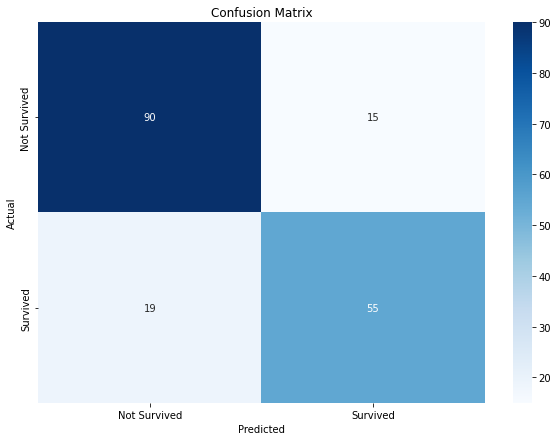

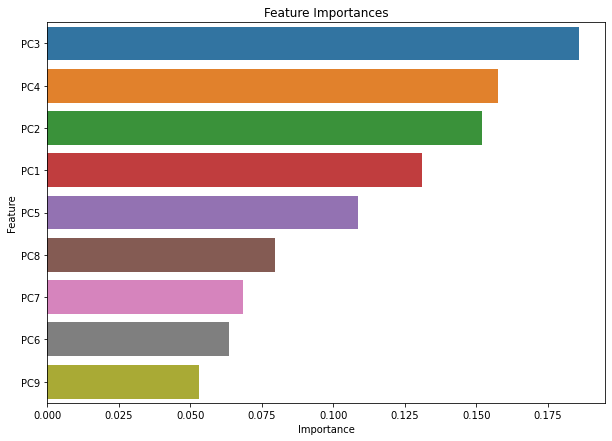

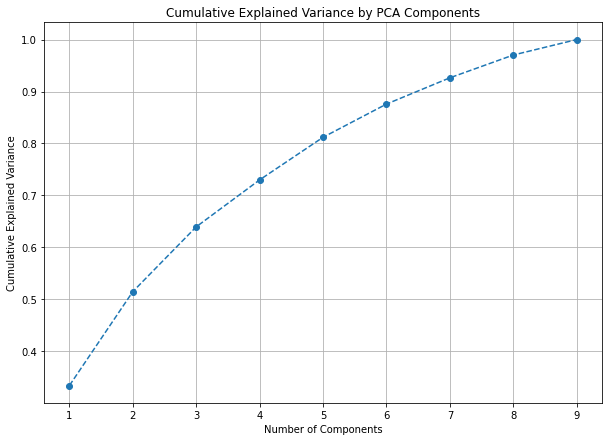

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, confusion_matrix, classification_report, accuracy_score

# Charger les données
df = pd.read_csv('train.csv')

# Ingénierie des caractéristiques
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# Supprimer les colonnes non informatives
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Gérer les valeurs manquantes
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Encoder les variables catégorielles
le_sex = LabelEncoder()
le_embarked = LabelEncoder()
le_title = LabelEncoder()

df['Sex'] = le_sex.fit_transform(df['Sex'])
df['Embarked'] = le_embarked.fit_transform(df['Embarked'])
df['Title'] = le_title.fit_transform(df['Title'])

# Définir les caractéristiques et la cible
X = df.drop('Survived', axis=1)
y = df['Survived']

# Pipeline de transformation et de classification
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Paramètres pour la recherche de grille
param_grid = {
    'pca__n_components': [0.90, 0.95, 0.99],
    'classifier__n_estimators': [100, 200, 300, 400],
    'classifier__max_depth': [10, 20, 30, 40],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4, 6]
}
# RMSE scorer
rmse_scorer = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False), greater_is_better=False)

# Recherche de grille avec validation croisée
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring=rmse_scorer, verbose=2)
grid_search.fit(X, y)

# Meilleurs paramètres
print(f'Best parameters: {grid_search.best_params_}')

# Meilleur modèle
best_model = grid_search.best_estimator_

# Séparer les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le meilleur modèle
best_model.fit(X_train, y_train)

# Prédictions
y_pred = best_model.predict(X_test)

# Calculer et afficher la RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Calculer l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Rapport de classification
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

# Plots
# Matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Importance des caractéristiques
features_importance = best_model.named_steps['classifier'].feature_importances_
# After PCA, features names are not directly available, hence using indices
features_names = [f'PC{i+1}' for i in range(len(features_importance))]
importance_df = pd.DataFrame({'Feature': features_names, 'Importance': features_importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

# Variance expliquée par chaque composante principale
pca = best_model.named_steps['pca']
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 7))
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Charger les données de test
test_df = pd.read_csv('test.csv')

# Ingénierie des caractéristiques sur les données de test
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1
test_df['IsAlone'] = (test_df['FamilySize'] == 1).astype(int)
test_df['Title'] = test_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# Supprimer les colonnes non informatives
test_df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Gérer les valeurs manquantes
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)
test_df['Embarked'].fillna(test_df['Embarked'].mode()[0], inplace=True)

# Fonction pour gérer les nouvelles valeurs
def transform_with_unknowns(le, labels):
    known_labels = set(le.classes_)
    new_labels = set(labels) - known_labels
    le.classes_ = np.append(le.classes_, list(new_labels))
    return le.transform(labels)

# Encoder les variables catégorielles en utilisant les mêmes encodeurs que pour les données d'entraînement
test_df['Sex'] = transform_with_unknowns(le_sex, test_df['Sex'])
test_df['Embarked'] = transform_with_unknowns(le_embarked, test_df['Embarked'])
test_df['Title'] = transform_with_unknowns(le_title, test_df['Title'])

# Définir les caractéristiques
X_test_final = test_df.drop('PassengerId', axis=1)

# Normaliser les caractéristiques
X_test_final = best_model.named_steps['scaler'].transform(X_test_final)

# Appliquer la PCA
X_test_final = best_model.named_steps['pca'].transform(X_test_final)

# Prédictions pour le test set
test_df['Survived'] = best_model.named_steps['classifier'].predict(X_test_final)

# Sauvegarder les prédictions
submission = test_df[['PassengerId', 'Survived']]
submission.to_csv('submission.csv', index=False)
